In [1]:
import os
import sys

import pandas as pd
import pandas_datareader.data as web
import numpy as np
import networkx as nx

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 3)

In [23]:
import redis

cache_ip = '198.13.60.78'
cache_pw = 'da56038fa453c22d2c46e83179126e97d4d272d02ece83eb83a97357e842d065'

r = redis.StrictRedis(host=cache_ip, port=6379, password=cache_pw)

In [31]:
kp = pd.read_msgpack(r.get('I.001_INDEX'))['cls_prc']
kd = pd.read_msgpack(r.get('I.201_INDEX'))['cls_prc']

index = pd.DataFrame()
index['KOSPI'] = kp
index['KOSDAQ'] = kd

In [32]:
index

,KOSPI,KOSDAQ
0,2031.10,501.61
1,2019.41,499.07
2,2011.94,504.84
3,2011.25,508.72
4,1997.94,509.01
5,1991.81,511.94
6,2006.80,514.48
7,1996.67,515.42
8,2007.04,513.44
9,1983.74,508.02


### 주식 시장에 뛰어들다

경제도 배우고, 통계도 배우고, 주식도 배웠다. 고급 기법을 모두 적용해서 최고의 수익률을 낼 수 있는 투자 시스템을 만들겠다고 다짐했다.

어떻게 접근할 수 있을까?

## 통계 & 시계열 분석

통계와 시계열 분석은 과거를 이해하고 미래를 예측하려는 시도이다.

In [17]:
# 해외 데이터 불러오기
start = '2000-01-01'
end = '2018-09-01'

get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY', 'TLT', 'MSFT']
data = pd.DataFrame({sym: get_px(sym) for sym in symbols})
lrets = np.log(data / data.shift(1)).dropna()

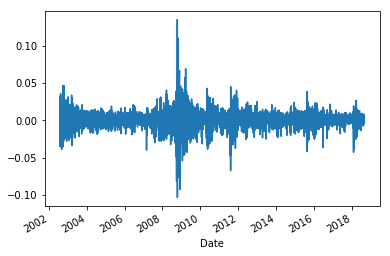

In [21]:
lrets['SPY'].plot()
plt.show()

In [ ]:
def get_px(x):
    return web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

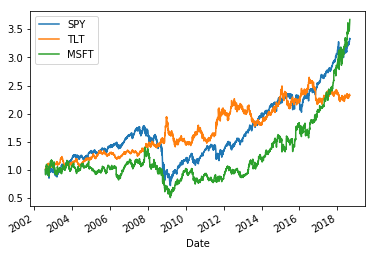

In [3]:
(lrets + 1).cumprod().plot()

### 1. Stationarity

- 데이터가 시간에 의존하지 않는다. 즉, 가격의 트렌드가 없다.
- 분산은 시간에 의존하지 않는다. 즉, 분산의 트렌드가 없다.
- 공분산은 시간에 의존하지 않는다. 즉, 공분산의 트렌드가 없다.

Stationary(변화가 없다)한 시계열 데이터를 분석해야지만, 지금 분석한 성질이 미래에도 이어진다. 만약, stationary하지 않다면, 현재 분석한 어떤 통계 자료도 미래에는 유의미하지 않을 것이다.

### 결국, 금융 데이터 분석에서 제일 중요한 것은 데이터가 stationary한지 안 한지 판단하고, 그렇지 않다면 stationary하게 바꿔주는 작업이다.

여기서 중요한 개념은: Serial Correlation(=Autocorrelation)이다.
Stationary한 데이터의 에러값은 autocorrelation이 없다. 이 말은, 에러값들끼리 과거와는 독립적으로 움직인다는 것이다. 에러값에 트렌드가 보여서는 안 된다.

#### White Noise (Random Walk, Independent and Identically Distributed, i.i.d)

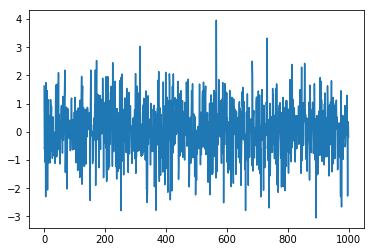

In [35]:
np.random.seed(1)
random_data = np.random.normal(size=1000)

plt.plot(random_data)
plt.show()

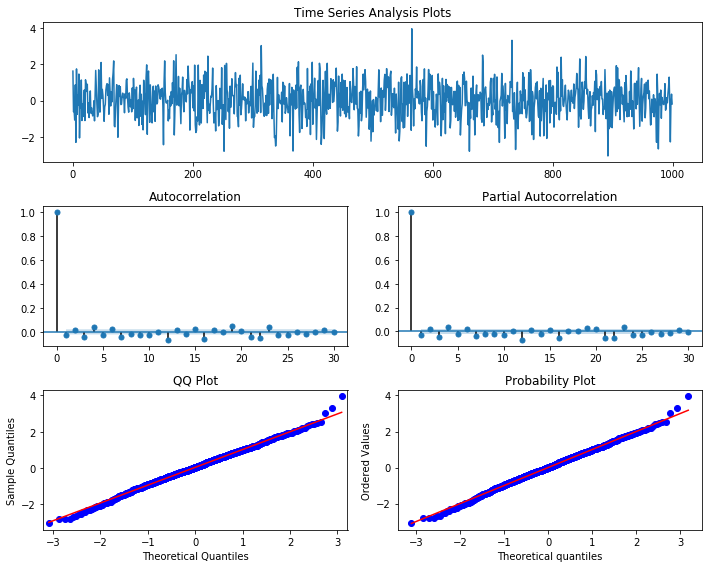

In [5]:
y = random_data
lags = 30

if not isinstance(y, pd.Series):
    y = pd.Series(random_data)
     
fig = plt.figure(figsize=(10, 8))

layout = (3, 2)

ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
acf_ax = plt.subplot2grid(layout, (1, 0))
pacf_ax = plt.subplot2grid(layout, (1, 1))
qq_ax = plt.subplot2grid(layout, (2, 0))
pp_ax = plt.subplot2grid(layout, (2, 1))

y.plot(ax=ts_ax)
ts_ax.set_title('Time Series Analysis Plots')
smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
sm.qqplot(y, line='s', ax=qq_ax)
qq_ax.set_title('QQ Plot')        
scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

plt.tight_layout()

In [39]:
def tsplot(y, lags=None):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    print('Random Series')
    print('Mean: {:.3f}'.format(y.mean()))
    print('Variance: {:.3f}'.format(y.var()))
    print('Standard Deviation: {:.3f}'.format(y.std()))

    fig = plt.figure(figsize=(10, 8))

    layout = (3, 2)

    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    qq_ax = plt.subplot2grid(layout, (2, 0))
    pp_ax = plt.subplot2grid(layout, (2, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title('Time Series Analysis Plots')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
    sm.qqplot(y, line='s', ax=qq_ax)
    qq_ax.set_title('QQ Plot')        
    scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

    plt.tight_layout()

Random Series
Mean: 0.039
Variance: 0.963
Standard Deviation: 0.981


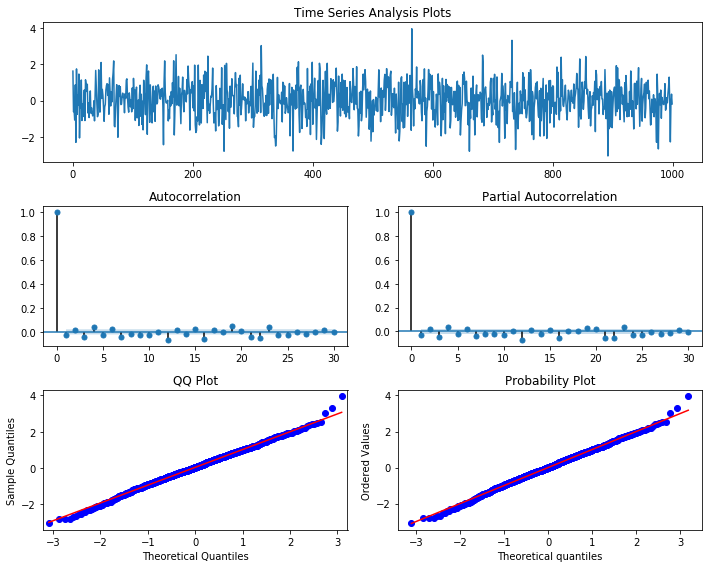

In [7]:
tsplot(random_data, 30)

#### Random Walk

랜덤워크는:

X(t) = X(t-1) + w(t)

로 모델링되는 시계열 데이터이고, w(t)가 white noise이다. 결국, 과거에 의존한 트렌드성 데이터이기 때문이기 때문에 미래 예측이 불가능하다.

Random Series
Mean: 24.322
Variance: 145.459
Standard Deviation: 12.061


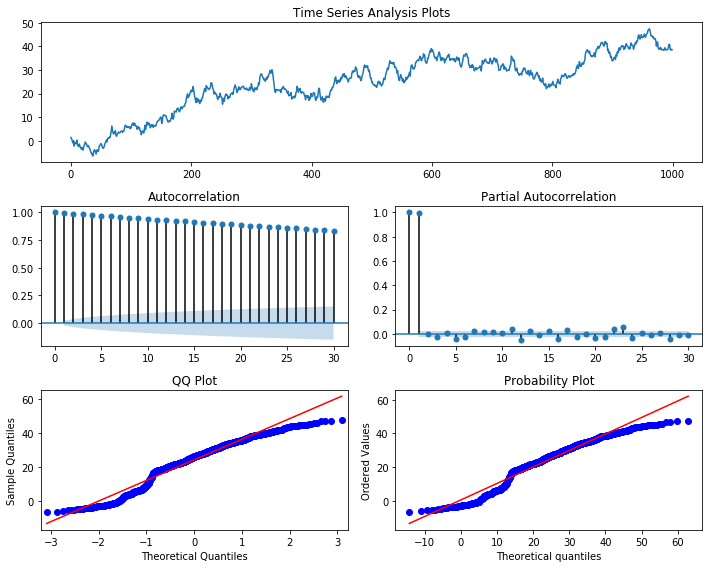

In [40]:
# 랜덤워크 데이터 만들기
np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t - 1] + w[t]

tsplot(x, lags=30)

Random Series
Mean: 0.037
Variance: 0.962
Standard Deviation: 0.981


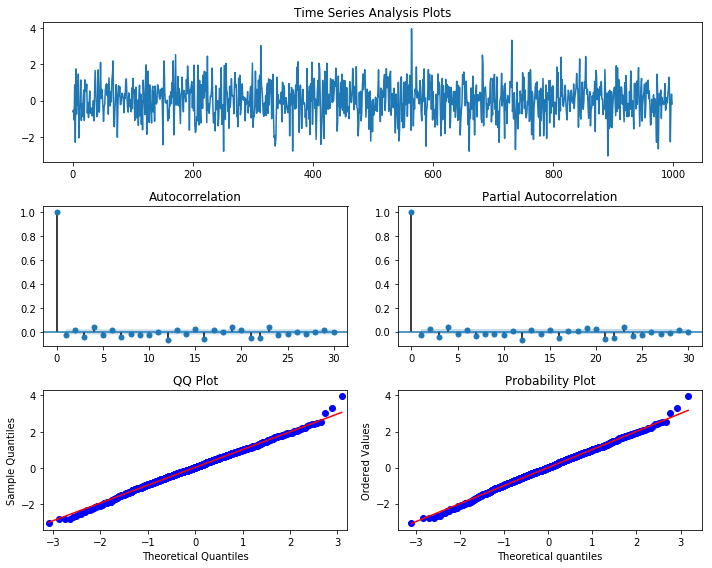

In [9]:
# Random Walk는 difference를 취해주면 white noise를 만들 수 있다
# X(t) - X(t-1) = w(t)
tsplot(np.diff(x), lags=30)

Random Series
Mean: 0.039
Variance: 1.715
Standard Deviation: 1.310


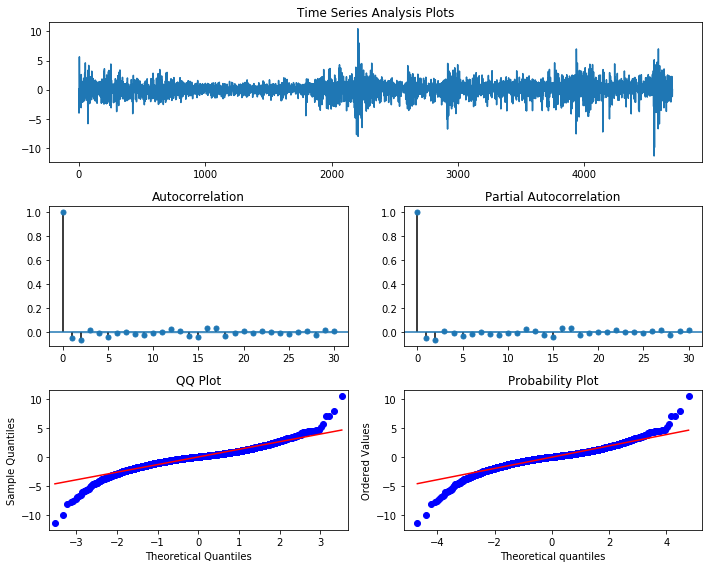

In [10]:
# SPY를 가지고 difference를 취해보겠다
tsplot(np.diff(data.SPY), lags=30)

#### Linear Models

sales 예측 --> 추후 보겠지만, 이런 모델은 비현실적이다. 통계의 문제를 직접적으로 건드리는 부분이다.

과거의 패턴을 분석하는 것은 과거와 같은 일이 발생할 것이라는 믿음을 기반으로 이루어진다.

In [11]:
w = np.random.randn(100)
y = np.empty_like(w)

In [17]:
# 첫 매출이 -50이고 꾸준히 25씩 증가한 회사를 가정
b0 = -50
b1 = 25

for t in range(len(w)):
    y[t] = b0 + b1 * t + w[t]

Random Series
Mean: 1187.535
Variance: 526265.122
Standard Deviation: 725.441


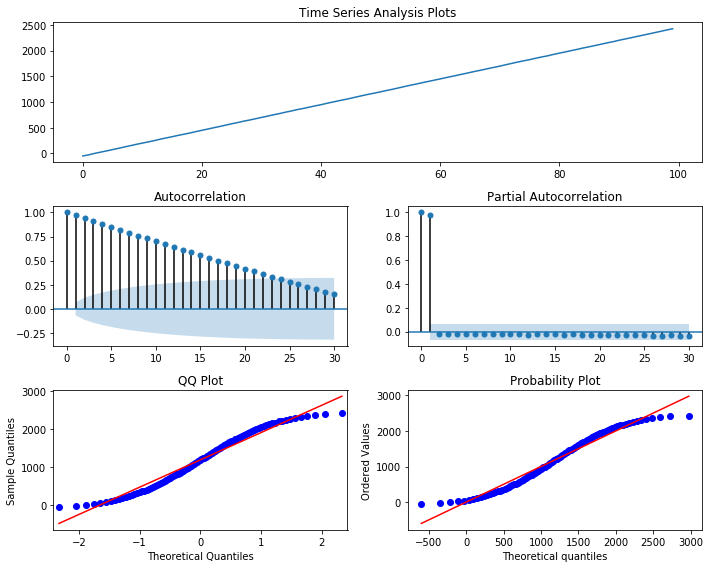

In [16]:
tsplot(y, lags=30)

In [26]:
y_df = pd.DataFrame(y)
y_df['lag_1'] = y_df[0].shift(1)
y_df['AR1'] = y_df[0] - y_df['lag_1']
y_ar = list(y_df['AR1'])

Random Series
Mean: 25.005
Variance: 1.961
Standard Deviation: 1.401


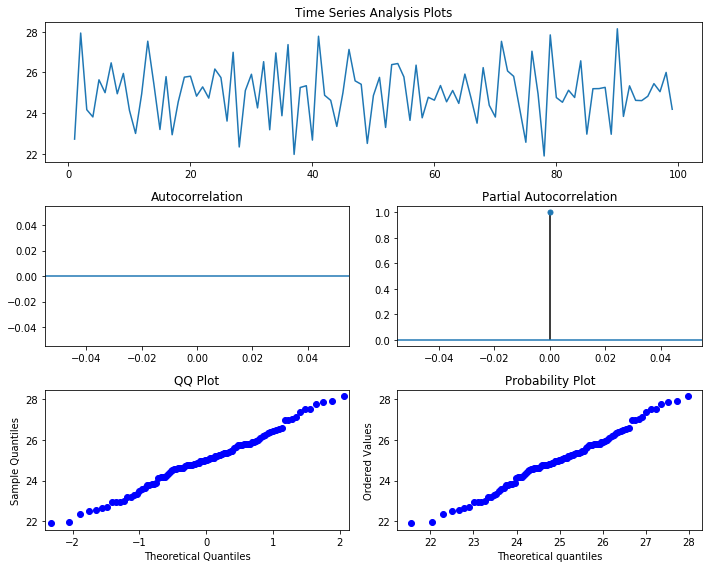

In [27]:
tsplot(y_ar, lags=30)

## Autoregressive Models - AR(p)

종속 변수가 과거 동일 변수의 값들에 의존하면 autoregressive라고 한다.

X(t) = a1 * X(t - 1) + ... + ap * X(t - p) + w(t)

여기서, 예를 들면 AR(2) 모델은: X(t) = a1 * X(t - 1) + a2 * X(t -2) + w(t) 가 된다.

AR(1) 모델에서 a1이 1이면 랜덤워크와 같다. 그리고 w(t)는 white noise이다.

Random Series
Mean: 0.097
Variance: 1.449
Standard Deviation: 1.204


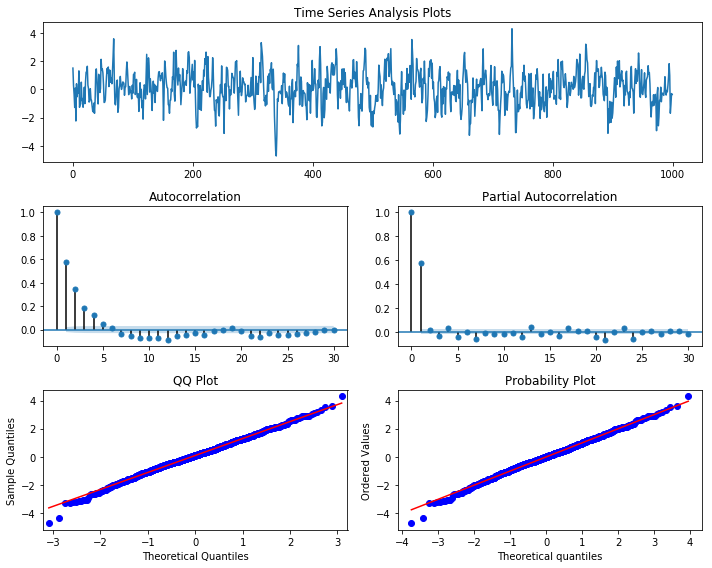

In [41]:
# AR(1)
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a * x[t - 1] + w[t]
    
tsplot(x, lags=30)

In [42]:
model = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc') # a를 예측
est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc') # lag를 얼마나 해야할지

In [33]:
model.params[0]

0.582266136324811

In [34]:
est_order

1

Random Series
Mean: 0.040
Variance: 1.609
Standard Deviation: 1.269


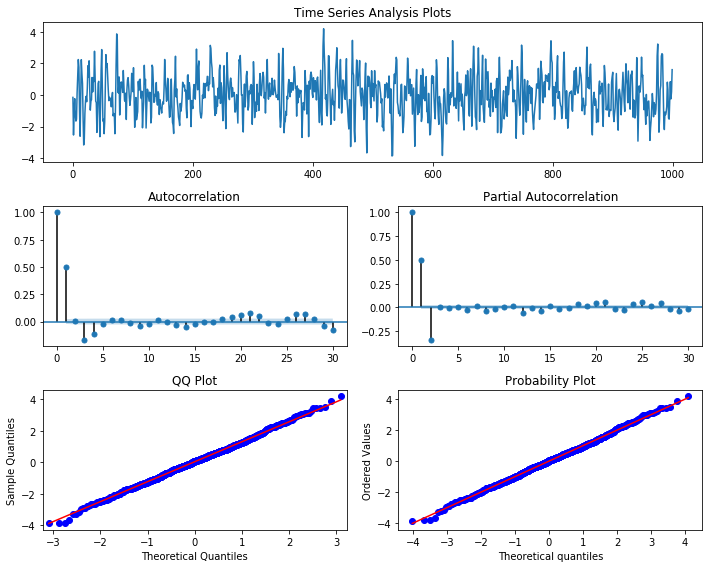

In [47]:
# AR(2)
# statsmodel에서 제공해주는 ARMA 모델 샘플링 함수로 AR(2) 모델을 만든다
n = int(1000)
alphas = np.array([0.666, -0.333])
betas = np.array([0])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ar2, lags=30)

In [48]:
model = smt.AR(ar2).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=30, ic='aic', trend='nc')

In [49]:
model.params

array([ 0.6759911, -0.3392767])

In [50]:
est_order

2

In [51]:
### MSFT 리턴 데이터에 AR 모델 맞춰보기
model = smt.AR(lrets.MSFT).fit(maxlag=30, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(maxlag=30, ic='aic', trend='nc')

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [52]:
model.params

L1.MSFT    -0.072458
L2.MSFT    -0.043499
L3.MSFT     0.029914
L4.MSFT    -0.040172
L5.MSFT    -0.034320
L6.MSFT    -0.012953
L7.MSFT    -0.047623
L8.MSFT    -0.020978
L9.MSFT    -0.024888
L10.MSFT    0.025947
L11.MSFT    0.031547
L12.MSFT    0.031955
L13.MSFT   -0.017973
L14.MSFT   -0.000162
L15.MSFT   -0.006502
L16.MSFT    0.011070
L17.MSFT    0.036500
L18.MSFT   -0.037639
dtype: float64

In [53]:
est_order

3

Random Series
Mean: 0.001
Variance: 0.000
Standard Deviation: 0.016


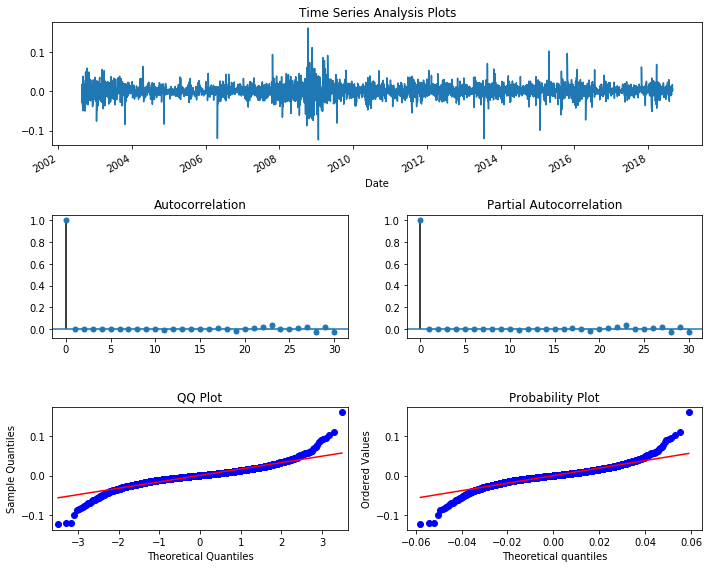

In [54]:
tsplot(model.resid, lags=30)

In [55]:
msft = lrets.MSFT
msft_resid = model.resid.shift(1).rolling(5).mean()
msft_est = -1 * model.params[0] * msft.shift(1) + (-1) * model.params[1] * msft.shift(2) + (-1) * model.params[2] * msft.shift(3) + msft_resid

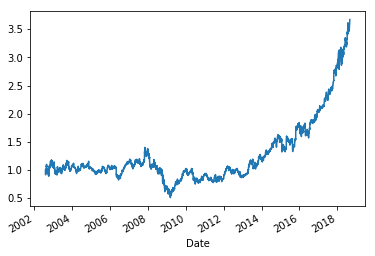

In [56]:
(msft + 1).cumprod().plot()
plt.show()

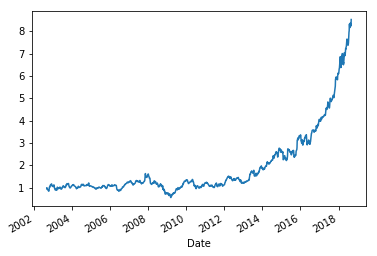

In [57]:
(msft_est + 1).cumprod().plot()
plt.show()

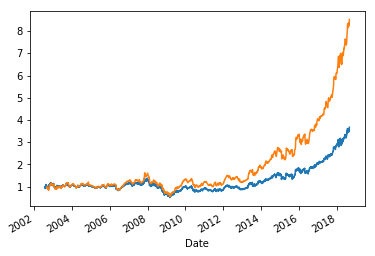

In [58]:
(msft + 1).cumprod().plot()
(msft_est + 1).cumprod().plot()
plt.show()

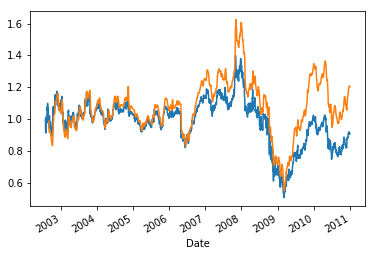

In [59]:
(msft + 1).cumprod()['2002':'2010'].plot()
(msft_est + 1).cumprod()['2002':'2010'].plot()
plt.show()

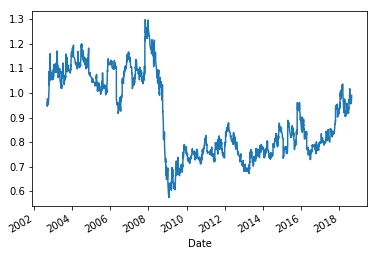

In [89]:
(msft[msft_est > 0] + 1).cumprod().plot()
plt.show()

## Moving Average Models - MA(q)

AR모델이 변수 자체의 시간적 종속성을 보여주는 것이라면, MA 모델은 에러텀의 과거 에러텀들과의 상관성을 잡아주는 모델이다.

MA(q) 모델은: X(t) = w(t) + b1 * w(t - 1) + ... + bq * w(t - q) 이다. 여기서 E[w(t)] = 0 이다.

Random Series
Mean: 0.005
Variance: 1.389
Standard Deviation: 1.179


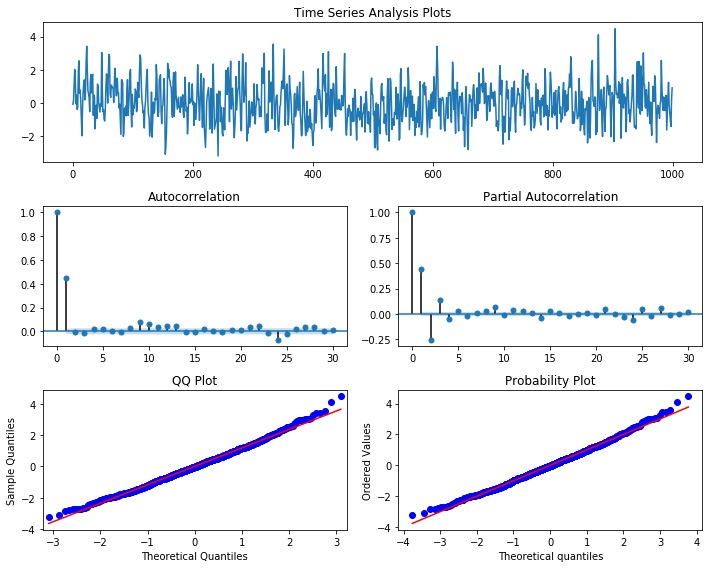

In [90]:
# MA(1)
n = int(1000)

alphas = np.array([0])
betas = np.array([0.6])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ma1, lags=30)

위의 ACF를 보면, beta값은 하나로 MA(1) 모델일 것임을 알 수 있다.
PACF를 보면, AR(4) 모델도 사용해야 한다고 하지만, 모델 fitting을 시키면, 그렇지 않을 것이다.

In [91]:
max_lag = 30
model = smt.ARMA(ma1, order=(0,1)).fit(maxlag=max_lag, method='mle', trend='nc')
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1427.789
Method:                           mle   S.D. of innovations              1.009
Date:                Wed, 26 Sep 2018   AIC                           2859.578
Time:                        19:10:15   BIC                           2869.393
Sample:                             0   HQIC                          2863.308
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5898      0.025     23.604      0.000       0.541       0.639
                                    Roots                                    
                  Real          Imaginary           M

Random Series
Mean: 0.159
Variance: 1.674
Standard Deviation: 1.294


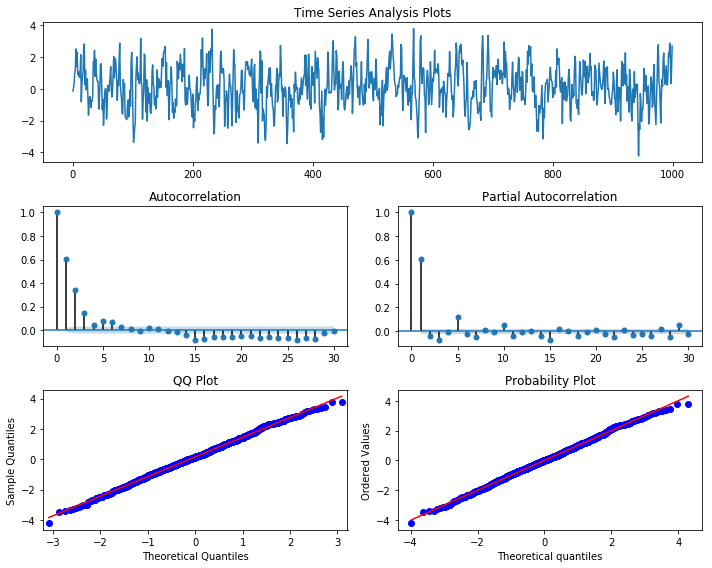

In [92]:
# MA(3)
n = int(1000)
alphas = np.array([0])
betas = np.array([0.6, 0.4, 0.2])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
tsplot(ma3, lags=30)

In [94]:
max_lag = 30
model = smt.ARMA(ma3, order=(0,3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1438.010
Method:                           mle   S.D. of innovations              1.019
Date:                Wed, 26 Sep 2018   AIC                           2884.020
Time:                        19:12:28   BIC                           2903.651
Sample:                             0   HQIC                          2891.481
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6443      0.031     20.736      0.000       0.583       0.705
ma.L2.y        0.4364      0.036     12.182      0.000       0.366       0.507
ma.L3.y        0.2103      0.031      6.802      0.0

Random Series
Mean: 0.000
Variance: 0.000
Standard Deviation: 0.012


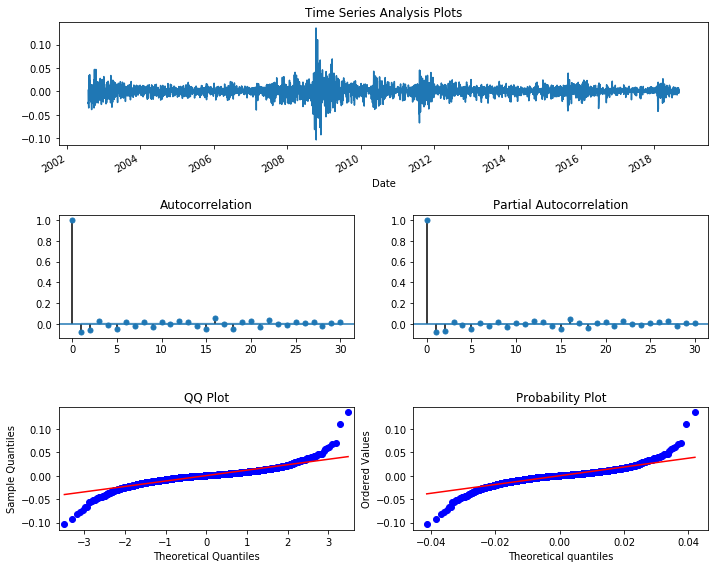

In [95]:
tsplot(lrets.SPY, lags=30)

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 4052
Model:                     ARMA(0, 3)   Log Likelihood               12316.523
Method:                           mle   S.D. of innovations              0.012
Date:                Wed, 26 Sep 2018   AIC                         -24625.046
Time:                        19:14:15   BIC                         -24599.819
Sample:                             0   HQIC                        -24616.110
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0828      0.016     -5.278      0.000      -0.114      -0.052
ma.L2.SPY     -0.0589      0.016     -3.680      0.000      -0.090      -0.028
ma.L3.SPY      0.0206      0.015      1.329      0.1

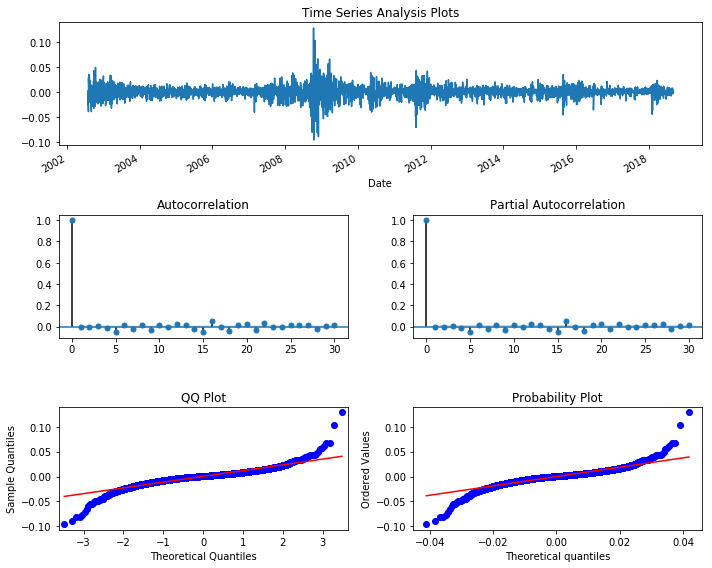

In [97]:
# SPY fitting
max_lag = 30
Y = lrets.SPY
model = smt.ARMA(Y, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(model.summary())
tsplot(model.resid, lags=max_lag)

## Autoregressive Moving Average Models - ARMA(p, q)

결국, AR 모델과 MA 모델을 조합하면 주가를 더 정확하게 예측할 수 있다. 물론 과거 패턴을 기반으로 미래 주가의 이동 방향을 예측하는 것이기 때문에 결과가 틀릴 확률이 높다.

AR 모델은 모멘텀과 평균 회귀 효과를 잡아내는 모델이고,  
MA 모델은 시장의 충격을 잡아내는 모델이다.

위의 두 모델을 함께 활용하면, 완변한 주가 예측 모델을 만들 수 있을 것 같지만, 실제로는 그렇지 않다. 이때까지 가격의 트렌드를 없애주는 작업을 했다면, 마찬가지로 분산과 공분산을 없애는 작업도 해야한다. Volatility Clustering 효과를 없애줘야 시장의 분산도 없애주는 것이다.

### ARMA(p, q)

X(t) = a1 * X(t - 1) + ... + ap * X(t - p) + b1 * w(t - 1) + ... + bq * w(t - q)

Random Series
Mean: -0.028
Variance: 2.071
Standard Deviation: 1.439
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7089.225
Method:                           mle   S.D. of innovations              0.999
Date:                Wed, 26 Sep 2018   AIC                          14188.451
Time:                        19:23:34   BIC                          14221.037
Sample:                             0   HQIC                         14199.871
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.4512      0.053      8.589      0.000       0.348       0.554
ar.L2.y       -0.2608      0.015    -17.555      0.000      -0

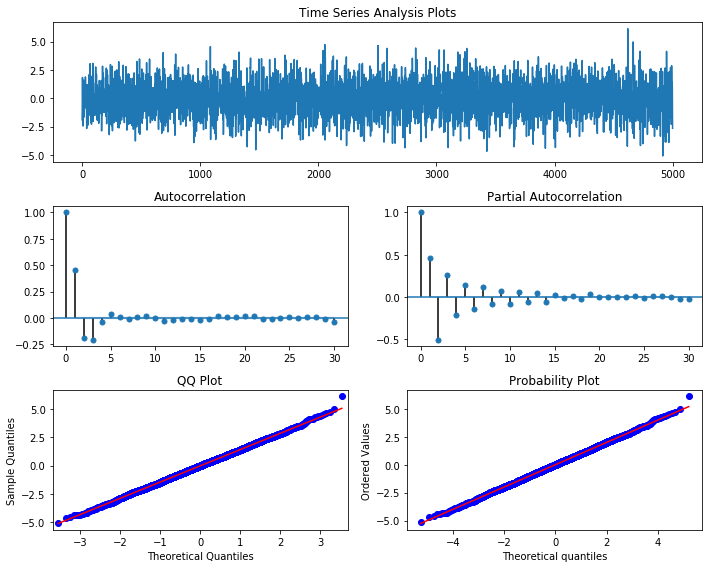

In [103]:
# ARMA(2, 2)
max_lag = 30

n = int(5000)
burn = int(n/10) # 샘플에서 제거하고 fitting할 데이터 수

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma22, lags=max_lag)

model = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(model.summary())

Random Series
Mean: -0.009
Variance: 2.369
Standard Deviation: 1.539
Fitting ARMA(0, 0)
Fitting ARMA(0, 1)
Fitting ARMA(0, 2)
Fitting ARMA(0, 3)
Fitting ARMA(0, 4)
Fitting ARMA(1, 0)
Fitting ARMA(1, 1)
Fitting ARMA(1, 2)
Fitting ARMA(1, 3)
Fitting ARMA(1, 4)
Fitting ARMA(2, 0)
Fitting ARMA(2, 1)
Fitting ARMA(2, 2)
Fitting ARMA(2, 3)
Fitting ARMA(2, 4)
Fitting ARMA(3, 0)
Fitting ARMA(3, 1)
Fitting ARMA(3, 2)
Fitting ARMA(3, 3)
Fitting ARMA(3, 4)
Fitting ARMA(4, 0)
Fitting ARMA(4, 1)
Fitting ARMA(4, 2)
Fitting ARMA(4, 3)
Fitting ARMA(4, 4)
aic: 14230.38648 | order: (3, 2)


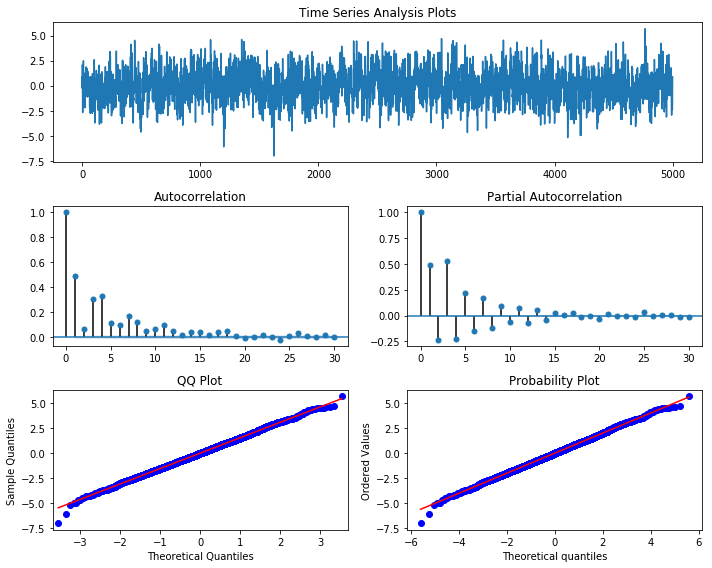

In [105]:
max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
tsplot(arma32, lags=max_lag)

# AIC를 비교해서 제일 좋은 모델을 찾는다
# AIC는 작으면 작을수록 좋다
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        print('Fitting ARMA({}, {})'.format(i, j))
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

In [107]:
# python은 제대로 된 모델을 찾아준다
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(3, 2)   Log Likelihood               -7109.193
Method:                           mle   S.D. of innovations              1.003
Date:                Wed, 26 Sep 2018   AIC                          14230.386
Time:                        19:30:40   BIC                          14269.490
Sample:                             0   HQIC                         14244.092
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.5019      0.033     15.041      0.000       0.436       0.567
ar.L2.y       -0.2507      0.016    -15.597      0.000      -0.282      -0.219
ar.L3.y        0.3940      0.014     28.519      0.000       0.367       0.421
ma.L1.y        0.5111      0.036     14.227      0.000       0.441       0.582
ma.L2.y       -0.2953      0.034     -8.658      0.000      -0.362      -0.228
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2470           -0.0000j            1.2470           -0.0000
AR.2           -0.3054           -1.3937j            1.4267           -0.2843
AR.3           -0.3054           +1.3937j            1.4267            0.2843
MA.1           -1.1681           +0.0000j            1.1681            0.5000
MA.2            2.8988           +0.0000j            2.8988            0.0000
-----------------------------------------------------------------------------
"""

Random Series
Mean: -0.003
Variance: 1.006
Standard Deviation: 1.003


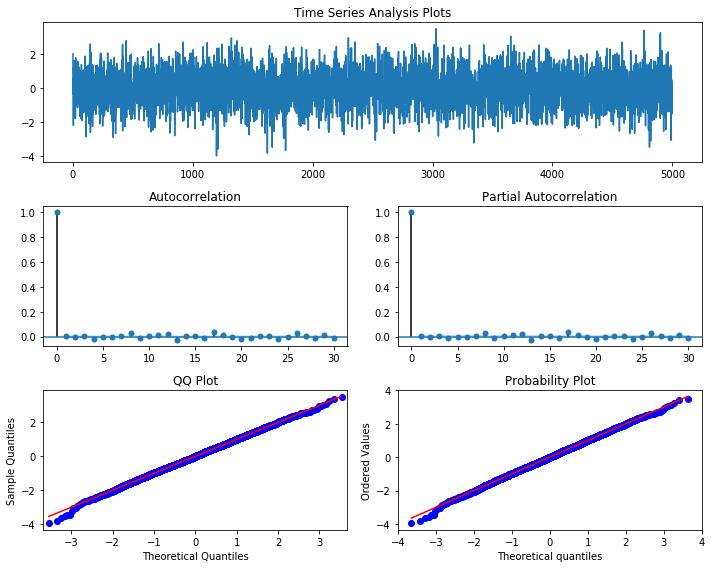

In [108]:
tsplot(best_mdl.resid, 30)

In [109]:
# SPY
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        print('Fitting ARMA({}, {})'.format(i, j))
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

Fitting ARMA(0, 0)
Fitting ARMA(0, 1)
Fitting ARMA(0, 2)
Fitting ARMA(0, 3)
Fitting ARMA(0, 4)
Fitting ARMA(1, 0)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, 

Fitting ARMA(1, 1)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(1, 2)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(1, 3)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(1, 4)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(2, 0)
Fitting ARMA(2, 1)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(2, 2)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(2, 3)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(2, 4)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(3, 0)
Fitting ARMA(3, 1)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(3, 2)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(3, 3)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(3, 4)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(4, 0)
Fitting ARMA(4, 1)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(4, 2)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(4, 3)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Fitting ARMA(4, 4)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -24644.13601 | order: (4, 3)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [110]:
best_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                    SPY   No. Observations:                 4052
Model:                     ARMA(4, 3)   Log Likelihood               12330.068
Method:                           mle   S.D. of innovations              0.012
Date:                Wed, 26 Sep 2018   AIC                         -24644.136
Time:                        19:34:15   BIC                         -24593.680
Sample:                             0   HQIC                        -24626.263
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.SPY     -0.1033      0.185     -0.558      0.577      -0.466       0.259
ar.L2.SPY     -0.5143      0.161     -3.191      0.001      -0.830      -0.198
ar.L3.SPY      0.6215      0.198      3.132      0.002       0.233       1.011
ar.L4.SPY      0.0118      0.028      0.419      0.675      -0.044       0.067
ma.L1.SPY      0.0216      0.184      0.117      0.907      -0.339       0.383
ma.L2.SPY      0.4607      0.139      3.324      0.001       0.189       0.732
ma.L3.SPY     -0.6729      0.178     -3.780      0.000      -1.022      -0.324
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.3710           -0.9390j            1.0096           -0.3099
AR.2           -0.3710           +0.9390j            1.0096            0.3099
AR.3            1.5544           -0.0000j            1.5544           -0.0000
AR.4          -53.3028           -0.0000j           53.3028           -0.5000
MA.1           -0.3736           -0.9478j            1.0188           -0.3098
MA.2           -0.3736           +0.9478j            1.0188            0.3098
MA.3            1.4319           -0.0000j            1.4319           -0.0000
-----------------------------------------------------------------------------
"""

Random Series
Mean: 0.000
Variance: 0.000
Standard Deviation: 0.012


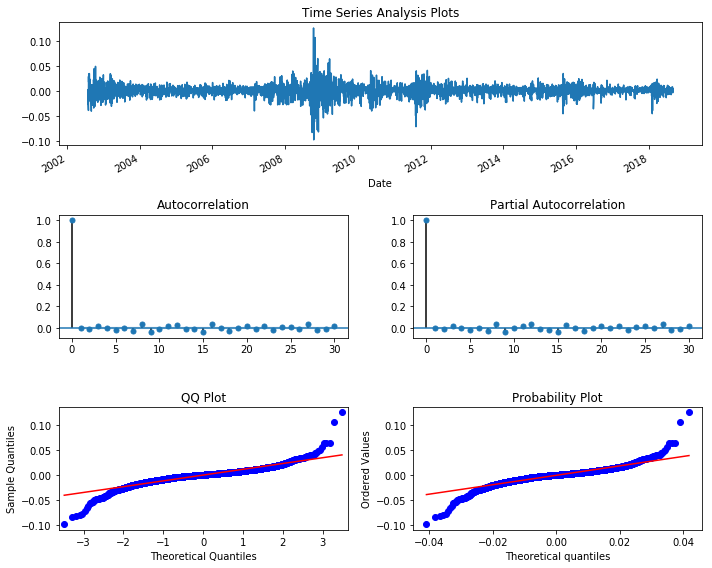

In [111]:
tsplot(best_mdl.resid, 30)

SPY를 ARMA 모델로 설명하면, residual은 white noise가 되지만, heteroskedasticity (conditional volatility)가 사라지지 않는다. 그래서 더 좋은 모델을 사용하여야 한다.

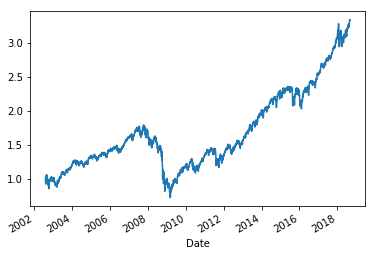

In [115]:
spy = lrets.SPY
(spy + 1).cumprod().plot()
plt.show()

In [124]:
spy_arma = pd.DataFrame()
spy_arma['SPY'] = spy
spy_arma['SPY ARMA'] = 0

ar_n = best_order[0]
ma_n = best_order[1]

# AR 부분
for n in range(ar_n):
    a = best_mdl.params[n]
    lag = n + 1
    spy_arma['SPY ARMA'] = spy_arma['SPY ARMA'] + (-1) * a * spy_arma['SPY'].shift(lag)
    
# MA 부분
for n in range(ma_n):
    param_n = ar_n + n
    a = best_mdl.params[param_n]
    lag = n + 1
    spy_arma['SPY ARMA'] = spy_arma['SPY ARMA'] + best_mdl.resid.shift(lag)

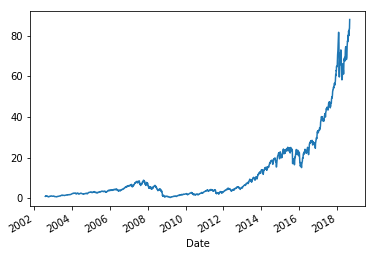

In [131]:
(spy_arma['SPY ARMA'] + 1).cumprod().plot()
plt.show()

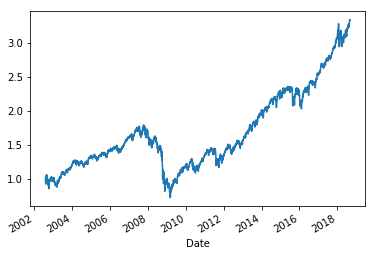

In [130]:
(spy + 1).cumprod().plot()
plt.show()

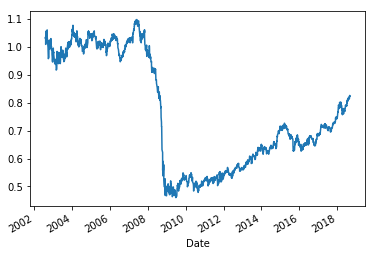

In [137]:
arma_bt = spy_arma['SPY'][spy_arma['SPY ARMA'] > 0]
(arma_bt + 1).cumprod().plot()
plt.show()

## Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

In [138]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, 

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, 

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, 

NameError: name 'p' is not defined

aic: -24644.13601 | order: (4, 0, 3)
Random Series
Mean: 0.000
Variance: 0.000
Standard Deviation: 0.012


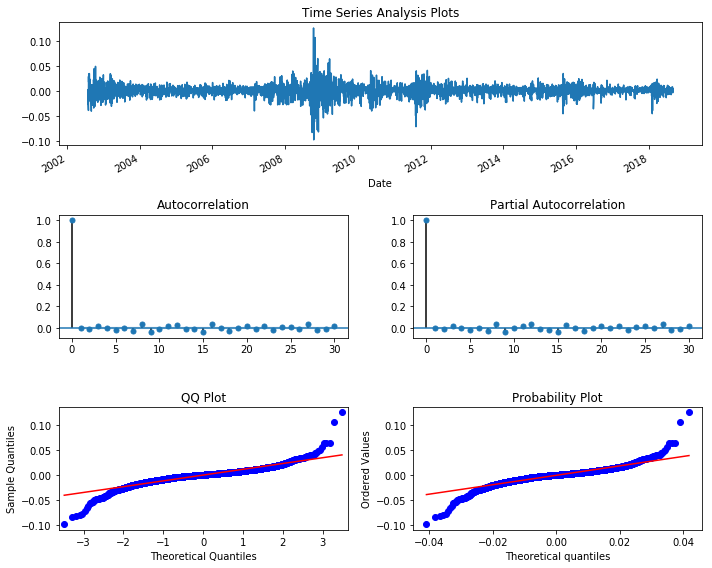

In [139]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
tsplot(best_mdl.resid, lags=30)

In [140]:
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2018-08-31,-0.000179,-0.022797,-0.029905,0.022439,0.029546
2018-09-01,0.000372,-0.022322,-0.029453,0.023066,0.030197
2018-09-02,-0.000445,-0.023162,-0.030300,0.022272,0.029410
2018-09-03,-0.000256,-0.022973,-0.030111,0.022461,0.029599
2018-09-04,0.000484,-0.022235,-0.029374,0.023204,0.030343


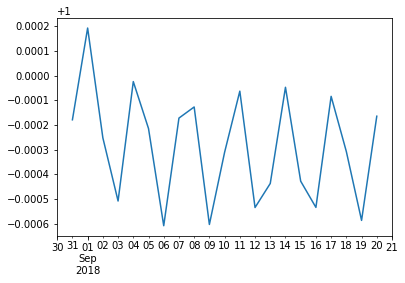

In [150]:
(fc_all['forecast'] + 1).cumprod().plot()
plt.show()

## Autoregressive Conditionally Heteroskedastic Models - ARCH(p)

ARCH(p) 모델은 시계열 모델의 분산(variance)에 AR(p) 모델을 취한 것과 같다.

Var(y(t) | y(t - 1)) = a0 + a1 * y(t - 1) ^ 2
y(t) = std(t) * e(t), std(t) = (a0 + a1 * y(t - 1) ^ 2) ^ (1/2)

Random Series
Mean: -0.024
Variance: 2.364
Standard Deviation: 1.538


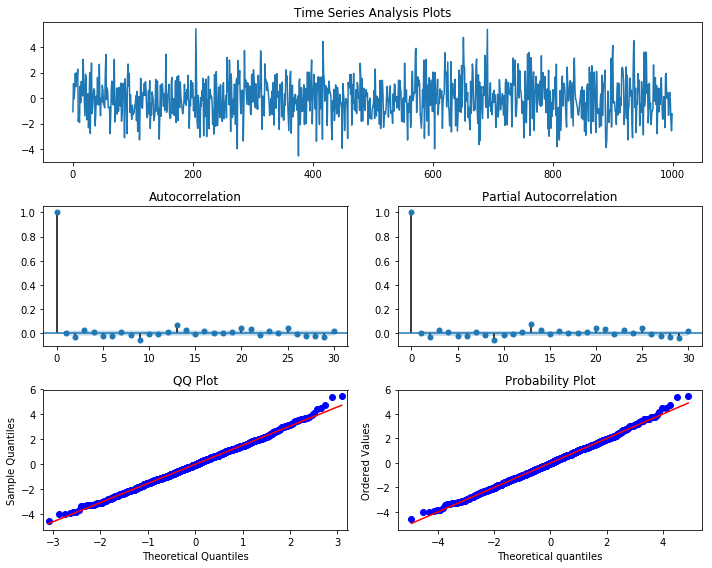

In [151]:
np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# white noise처럼 보이는 ARCH(1) 모델 보기
tsplot(Y, lags=30)

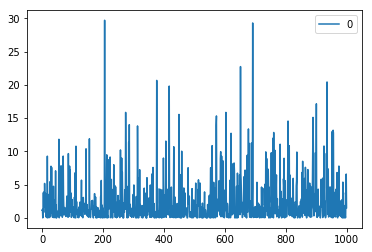

In [158]:
arch = pd.DataFrame(Y).apply(lambda x: x ** 2)
arch.plot()
plt.show()

Random Series
Mean: 2.362
Variance: 11.515
Standard Deviation: 3.393


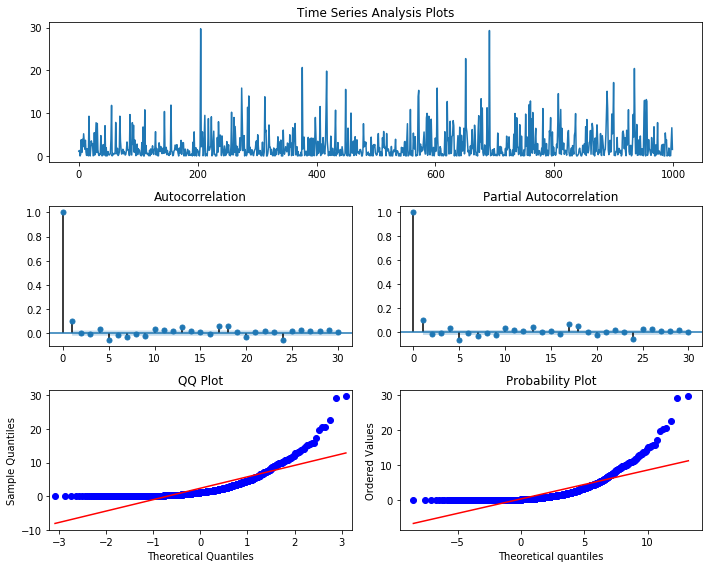

In [160]:
tsplot(arch[0], lags=30)

## Generalized Autoregressive Conditionally Heteroskedastic Models - GARCH(p,q)

GARCH(p, q) 모델은 시계열 모델의 분산에 ARMA 모델을 적용시킨 것이다. AR(p) 모델은 에러텀 제곱의 분산을 모델링하고, MA(q)는 시계열 모델 자체의 분산을 모델링한다.

e(t) = std(t) * w(t)  
var(t) = a0 + a1 * e(t - 1)^2 + b1 * var(t - 1)

Reference: http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

Random Series
Mean: -0.022
Variance: 0.954
Standard Deviation: 0.977


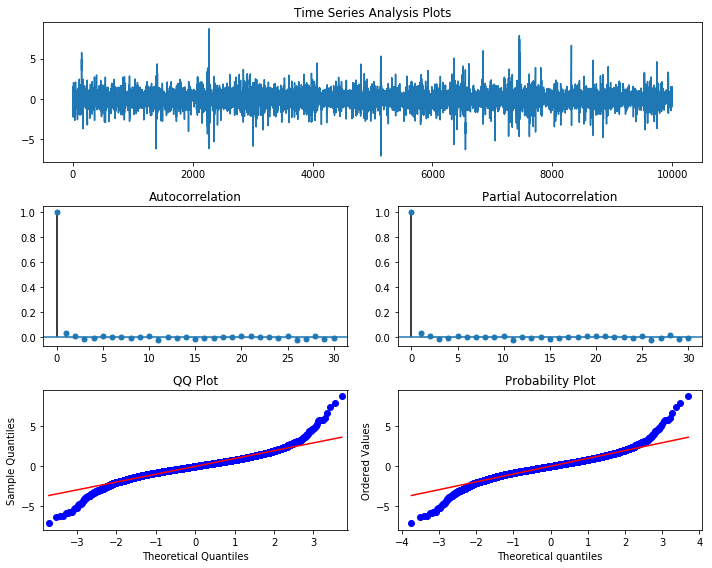

In [161]:
np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

tsplot(eps, lags=30)

Random Series
Mean: 0.955
Variance: 6.800
Standard Deviation: 2.608


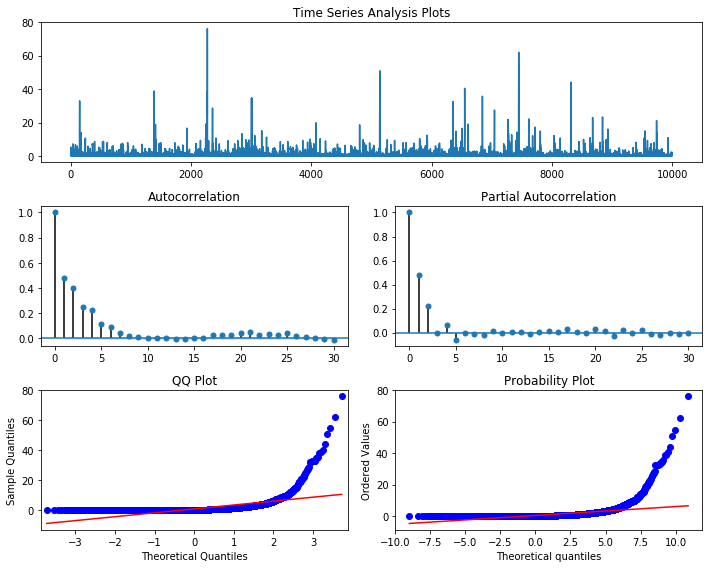

In [162]:
tsplot(eps ** 2, 30)

In [163]:
am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592658753043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.30326731947
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Thu, Sep 27 2018   Df Residuals:                     9996
Time:       

In [165]:
# SPY 예시
# 1. ARIMA(p, d, q) 모델을 하여 가장 주가의 움직임을 잘 나타내는 모델을 찾는다
# 2. GARCH 모델을 찾는다. 가장 낮은 AIC로 판단한다.
# 3. 마지막으로 남는 에러텀이 white noise인지 확인한다.

In [166]:
def get_best_model(ts):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(ts, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

ts = lrets.SPY.ix['2014':]
res_tup = get_best_model(ts)

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date in

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, 

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, 

aic: -8060.64638 | order: (4, 0, 3)


In [171]:
best_order = res_tup[1]
best_mdl = res_tup[2]

Random Series
Mean: 0.001
Variance: 0.000
Standard Deviation: 0.008


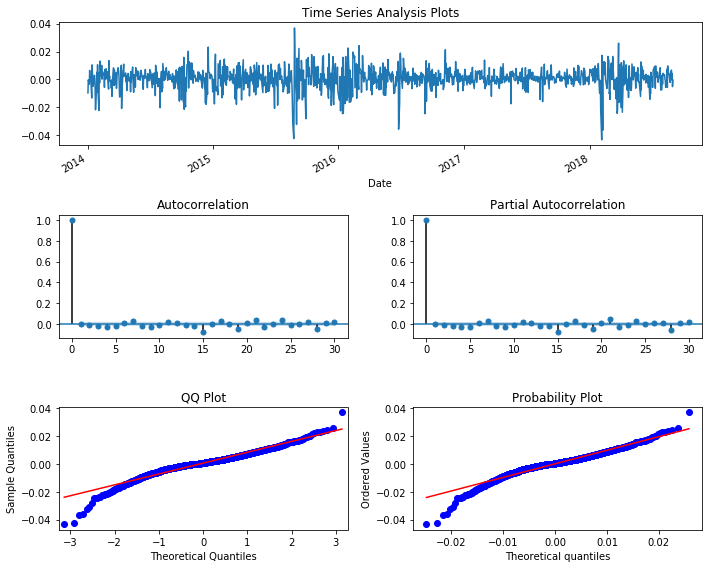

In [169]:
tsplot(best_mdl.resid, 30)

Random Series
Mean: 0.000
Variance: 0.000
Standard Deviation: 0.000


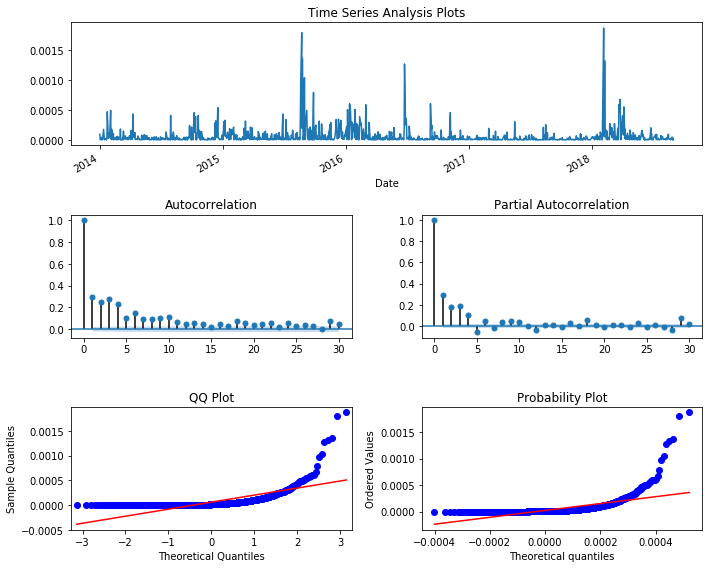

In [170]:
tsplot(best_mdl.resid ** 2, 30)

In [178]:
# GARCH 모델 피팅하기
p = best_order[0]
o = best_order[1]
q = best_order[2]

# Gaussian 분포보다는 T-distribution을 사용하는 것이 좋다
# arch_model을 사용하면, volatility clustering을 고려하여 모델을 피팅시켜준다
# 변동성 자체를 모델링할 것이면, ARIMA모델을 피팅시킨 후, residual을 가지고 온 후에 GARCH(p, q)
# 모델을 피팅하여 모델링해야 한다
am = arch_model(ts, p=p, o=o, q=q, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                           Constant Mean - GARCH Model Results                           
Dep. Variable:                          SPY   R-squared:          -615470074843963904.000
Mean Model:                   Constant Mean   Adj. R-squared:     -615470074843963904.000
Vol Model:                            GARCH   Log-Likelihood:                    -871317.
Distribution:      Standardized Student's t   AIC:                            1.74265e+06
Method:                  Maximum Likelihood   BIC:                            1.74270e+06
                                              No. Observations:                      1176
Date:                      Thu, Sep 27 2018   Df Residuals:                          1166
Time:                              06:57:37   Df Model:                                10
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
------------------------------------

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Random Series
Mean: -6166521.856
Variance: 0.000
Standard Deviation: 0.008


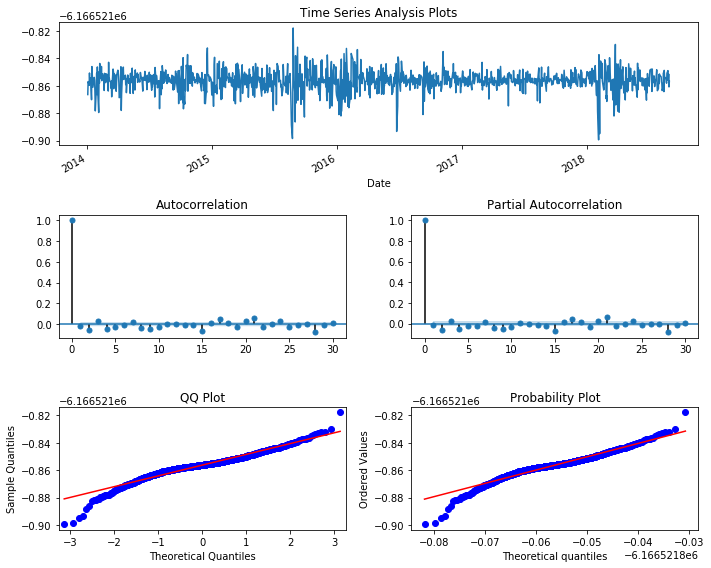

In [176]:
tsplot(res.resid, 30)

Random Series
Mean: 38025991804072.781
Variance: 9405537215.283
Standard Deviation: 96982.149


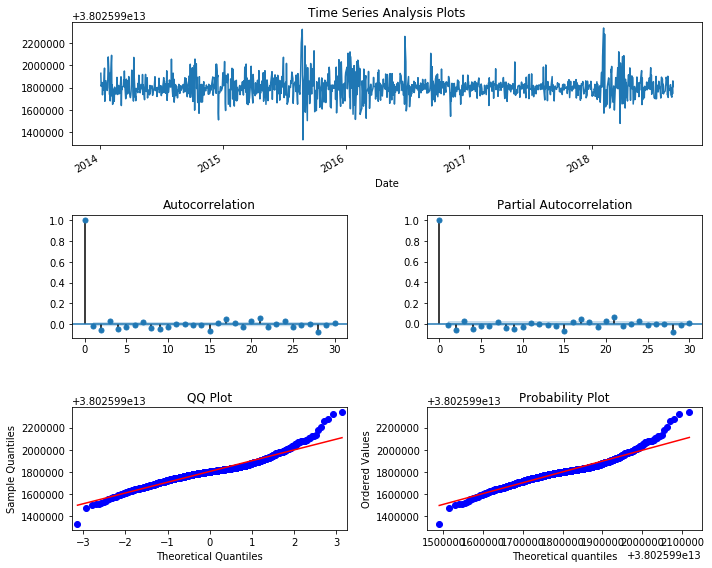

In [177]:
tsplot(res.resid ** 2, 30)

## ARIMA + GARCH 전략

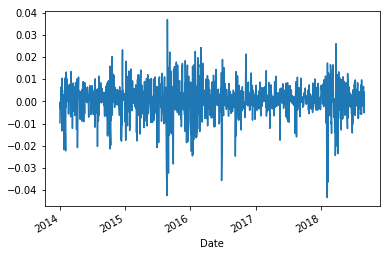

In [184]:
# 우선 변동성을 모델링해본다.
best_mdl.resid.plot()
plt.show()

In [271]:
w = best_mdl.resid
err = np.zeros_like(w)
var = np.zeros_like(w)

# GARCH(1, 1) 모델 사용
am = arch_model(w)
res = am.fit(update_freq=5)
print(res.summary())

a0 = res.params['omega']
a1 = res.params['alpha[1]']
b1 = res.params['beta[1]']

for i in range(1, len(w)):
    var[i] = a0 + a1 * (err[i - 1] ** 2) + b1 * var[i - 1]
    err[i] = w[i] * np.sqrt(var[i])

Iteration:      5,   Func. Count:     61,   Neg. LLF: -4186.091905111267
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4186.09190546077
            Iterations: 9
            Function evaluations: 61
            Gradient evaluations: 5
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.002
Mean Model:             Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                      GARCH   Log-Likelihood:                4186.09
Distribution:                  Normal   AIC:                          -8364.18
Method:            Maximum Likelihood   BIC:                          -8343.90
                                        No. Observations:                 1176
Date:                Thu, Sep 27 2018   Df Residuals:                     1172
Time:                        07:30:40   Df Model:                            4

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [253]:
def get_best_garch_model(ts):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = [1,2,3,4]
    for i in pq_rng:
        for j in pq_rng:
            try:
                tmp_mdl = arch_model(ts, vol='Garch', p=i, q=j)
                res = tmp_mdl.fit(update_freq=5)
                tmp_aic = res.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, j)
                    best_mdl = res
            except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

In [254]:
_, order, mdl = get_best_garch_model(w)

Iteration:      5,   Func. Count:     61,   Neg. LLF: -4186.091905111267
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4186.09190546077
            Iterations: 9
            Function evaluations: 61
            Gradient evaluations: 5
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4185.050226350238
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 3
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4182.967124053287
            Iterations: 8
            Function evaluations: 60
            Gradient evaluations: 4
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4178.4477291592675
            Iterations: 8
            Function evaluations: 62
            Gradient evaluations: 4


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivativ

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4180.222545590596
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 3
Iteration:      5,   Func. Count:     76,   Neg. LLF: -4180.386179859232
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4180.387869092194
            Iterations: 10
            Function evaluations: 92
            Gradient evaluations: 6
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4178.080141747876
            Iterations: 8
            Function evaluations: 62
            Gradient evaluations: 4


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     86,   Neg. LLF: -4175.64707491051
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4175.647374721417
            Iterations: 11
            Function evaluations: 124
            Gradient evaluations: 7
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4173.912579135167
            Iterations: 7
            Function evaluations: 42
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4172.411279359284
            Iterations: 3
            Function evaluations: 36
            Gradient evaluations: 2


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4171.069115918381
            Iterations: 8
            Function evaluations: 68
            Gradient evaluations: 4
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4168.992310780303
            Iterations: 6
            Function evaluations: 30
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4168.898424826117
            Iterations: 4
            Function evaluations: 54
            Gradient evaluations: 3


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4167.43897994461
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4165.676701844519
            Iterations: 2
            Function evaluations: 41
            Gradient evaluations: 2
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -4163.954967107584
            Iterations: 8
            Function evaluations: 74
            Gradient evaluations: 4
aic: -8364.18381 | order: (1, 1)


/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


In [272]:
volatility = pd.DataFrame(var)

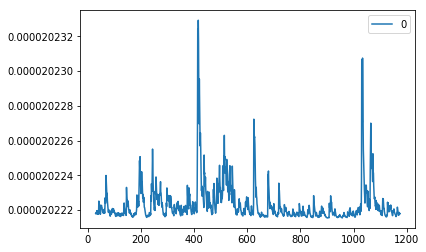

In [281]:
volatility.iloc[30:].plot()

In [331]:
spy = pd.DataFrame()
spy['SPY'] = list(lrets.SPY.ix['2014':].iloc[30:])
spy['SPY std'] = spy['SPY'].rolling(10).std()
spy['GARCH'] = list(volatility.iloc[30:][0])

spy_scaled = (spy['SPY std'] - spy['SPY std'].min()) / (spy['SPY std'] - spy['SPY std'].min()).max()
garch_scaled = (spy['GARCH'] - spy['GARCH'].min()) / (spy['GARCH'] - spy['GARCH'].min()).max()

/Users/abc/.virtualenvs/data/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


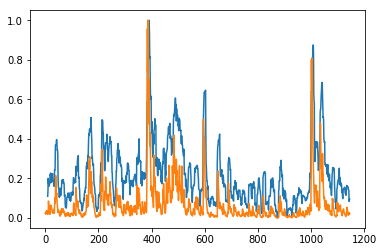

In [332]:
spy_scaled.plot()
garch_scaled.plot()
plt.show()

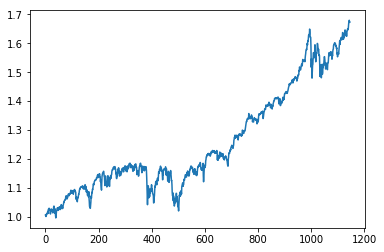

In [324]:
(spy_scaled

In [315]:
spy['GARCH'].max()

2.023292642360579e-05

In [317]:
spy['GARCH'].max() - spy['GARCH'].min()

1.138228215682085e-08

In [298]:
len(garch)

1

In [300]:
volatility.iloc[30:][0]

30      0.00002
31      0.00002
32      0.00002
33      0.00002
34      0.00002
35      0.00002
36      0.00002
37      0.00002
38      0.00002
39      0.00002
40      0.00002
41      0.00002
42      0.00002
43      0.00002
44      0.00002
45      0.00002
46      0.00002
47      0.00002
48      0.00002
49      0.00002
50      0.00002
51      0.00002
52      0.00002
53      0.00002
54      0.00002
55      0.00002
56      0.00002
57      0.00002
58      0.00002
59      0.00002
         ...   
1146    0.00002
1147    0.00002
1148    0.00002
1149    0.00002
1150    0.00002
1151    0.00002
1152    0.00002
1153    0.00002
1154    0.00002
1155    0.00002
1156    0.00002
1157    0.00002
1158    0.00002
1159    0.00002
1160    0.00002
1161    0.00002
1162    0.00002
1163    0.00002
1164    0.00002
1165    0.00002
1166    0.00002
1167    0.00002
1168    0.00002
1169    0.00002
1170    0.00002
1171    0.00002
1172    0.00002
1173    0.00002
1174    0.00002
1175    0.00002
Name: 0, Length: 1146, d

In [310]:
dd = pd.DataFrame([1, 2, 3, 4, 5, 10])
dd.max()

0    10
dtype: int64

In [309]:
dd

,0
0,1
1,2
2,3
3,4
4,5
5,10
